**Install dependencies**

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U triton xformers
# !pip install -U diffusers transformers accelerate jupyter huggingface-hub bitsandbytes tqdm;
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_diffusers_utils

**Import dependencies**

In [2]:
from pathlib import Path
import random
import os
from glob import glob

from PIL import Image
import numpy as np
from tqdm.auto import tqdm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

import torch  # PyTorch module for deep learning

# Import diffusers AutoencoderKL
from diffusers import AutoencoderKL

from cjm_pil_utils.core import get_img_files
from cjm_diffusers_utils.core import pil_to_latent, latent_to_pil
from cjm_pytorch_utils.core import get_torch_device

**Set HuggingFace Hub token**

In [3]:
# Import the notebook_login function from the huggingface_hub module
from huggingface_hub import notebook_login

# If the user does not have a an access token saved, prompt them to log in
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()

**Define path to dataset**

In [4]:
# dataset_path = Path(f"/mnt/980_1TB_2/Datasets/Pexels_Full_512p")
dataset_path = Path(f"/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg")

In [5]:
# Set the path for the images directory
img_dir = Path(dataset_path/"images/")

In [6]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


In [7]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {int(path.stem.split('-')[-1]) : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-color-1339845.jpg


**Get image IDs**

In [8]:
img_ids = list(img_path_dict.keys())

**Display sample image**

ID: 2901976


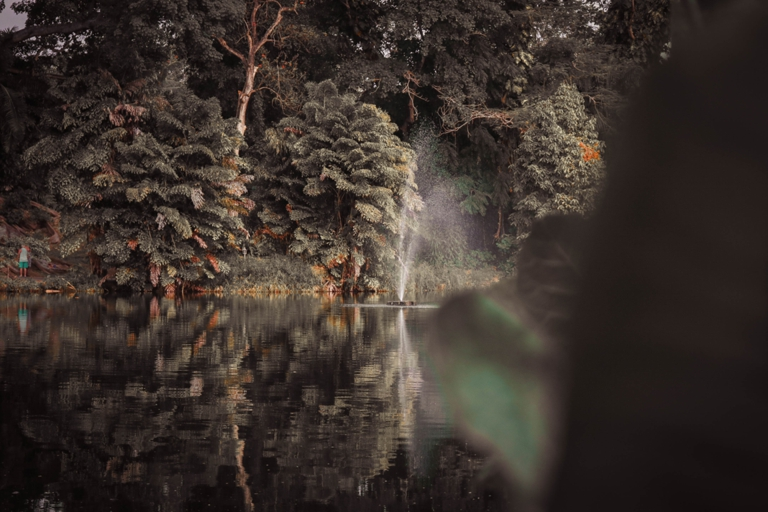

In [9]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids)
print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = img_path_dict[img_id]
sample_img = Image.open(img_path)

sample_img

**Select model**

In [10]:
model_name = "stabilityai/stable-diffusion-2-depth"
# model_name = "stabilityai/stable-diffusion-2-1-base"
# model_name = "stabilityai/stable-diffusion-2-1"

**Set PyTorch compute device**

In [11]:
device = get_torch_device()
device

'cuda'

**Set model data type**

In [12]:
weight_dtype = torch.float16

**Load VAE model**

In [13]:
vae = AutoencoderKL.from_pretrained(model_name, 
                                    subfolder="vae", 
                                    torch_dtype=weight_dtype).to(device)

**Convert sample image to latent space**

In [14]:
# %%timeit
img_latents = pil_to_latent(sample_img, vae)
img_latents.shape

torch.Size([1, 4, 64, 96])

**Decode latents to image**

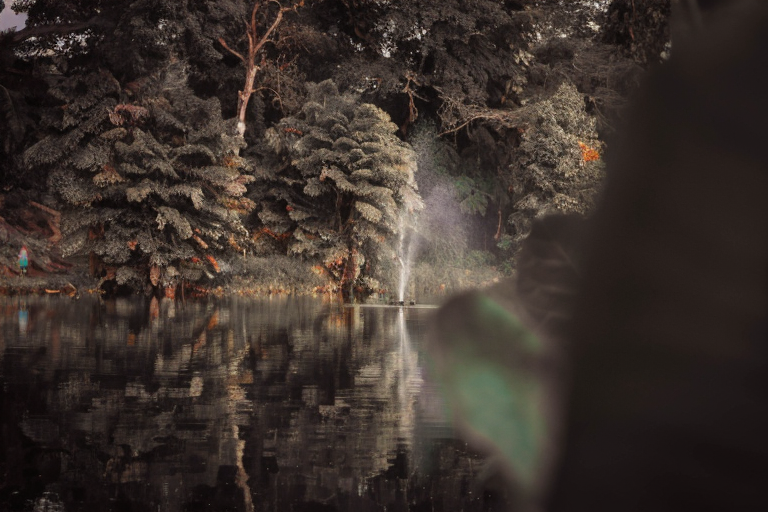

In [15]:
# %%timeit
image = latent_to_pil(img_latents, vae)
image

**Define function to apply to an array of image IDs**

In [16]:
def array_func(img_id, img_path_dict, vae, save_dir):
    """
    This function converts an image to latents using a VAE model, and saves the latents to a specified directory.
    
    Parameters:
    img_id (int): The id of the image to be converted.
    img_path_dict (dict): A dictionary with keys as image ids and values as image paths.
    vae (diffusers.AutoencoderKL): The VAE model used to convert the image to latents.
    save_dir (pathlib.Path): The directory to save the latents in.
    """
    
    # Open the image at the specified path
    image = Image.open(img_path_dict[img_id])
    
    # Convert the image to latents using the VAE model
    img_latents = pil_to_latent(image, vae)
    
    # Clear GPU cache
    if vae.device.type == 'cuda': torch.cuda.empty_cache()
    
    # Save the latents to the specified directory
    torch.save(img_latents, save_dir/f'latents-{img_id}.pt')

**Define save directory**

In [17]:
# Create a `Path` object for the directory that will be used to save the images.
save_dir = Path(dataset_path.parent/f"{model_name.split('/')[-1]}-{dataset_path.stem}-latents/tensors")

# Create the directory if it does not already exist.
save_dir.mkdir(parents=True, exist_ok=True)

# Print the `Path` object for the save directory.
save_dir

PosixPath('/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors')

**Test array function**

In [18]:
# Use the `array_func` function to 
array_func(img_id, img_path_dict, vae, save_dir)

# Get a list of the tensor file paths in the save directory
tensor_paths = glob(os.path.join(save_dir, "*.pt"))

# Display the list of tensor file paths as a DataFrame
pd.DataFrame(tensor_paths).head()

,0
0,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-2901976.pt


**Decode saved latents**

ID: 2901976


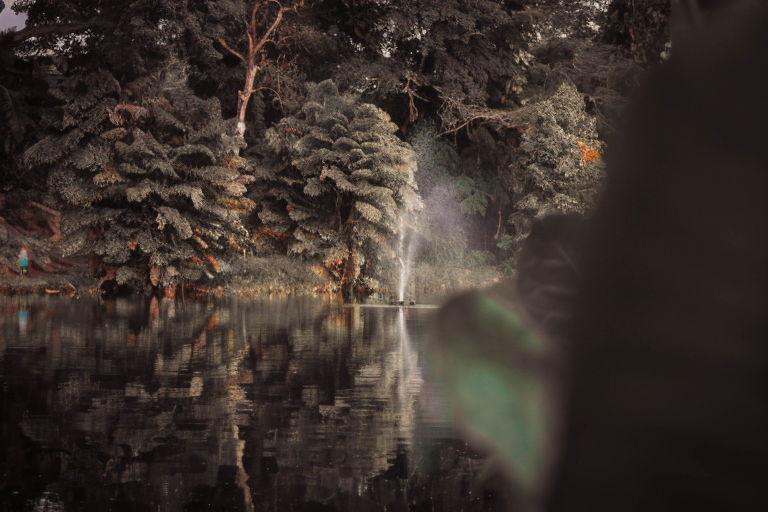

In [19]:
# Get the the path to the saved latents
tensor_path = Path(tensor_paths[0])

# Load the tensor
img_latents = torch.load(tensor_path)
decoded_img = latent_to_pil(img_latents, vae)

# Print the title of the image, located in the 'title' column of the attributes_df dataframe
print(f"ID: {tensor_path.stem.split('-')[-1]}")

# Display the downloaed image
decoded_img

**Encode images**

In [20]:
for img_id in tqdm(img_ids):
    array_func(img_id, img_path_dict, vae, save_dir)

  0%|          | 0/109971 [00:00<?, ?it/s]

**Get latent file paths**

In [21]:
# Get a list of the tensor file paths in the save directory
tensor_paths = glob(os.path.join(save_dir, "*.pt"))

print(f"Number of files: {len(tensor_paths)}")

# Display the list of tensor file paths as a DataFrame
pd.DataFrame(tensor_paths).head()

Number of files: 109971


,0
0,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000026.pt
1,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000037.pt
2,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000044.pt
3,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000054.pt
4,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000056.pt
